# Value at risk - market factors

In this notebook, we show how to
- train a linear regression model using historical market factor data for each instrument in portfolio
- ensure our market factors are not correlated and exhibit a normal distribution of market returns
- register all models to mlflow
- explore the use of pyfunc format

This notebook requires the following dependencies
- `mlflow`

### Authors
- Antoine Amend [<antoine.amend@databricks.com>]

# `STEP0` Configuration

In [3]:
%matplotlib inline

import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import mlflow

from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from datetime import datetime, timedelta

/databricks/python/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
 from collections import Mapping
/databricks/python/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
 defaults=argspec[3])

In [4]:
portfolio_table = 'var_portfolio'
stock_table = 'var_stock'
stock_return_table = 'var_stock_return'
market_table = 'var_market'
market_return_table = 'var_market_return'
trial_table = 'var_monte_carlo'

# when do we train model
today_str = "2019-06-01"
today = F.to_date(F.lit(today_str)).cast(TimestampType())
mlflow.log_param('to_date', today_str)

# our predictive market factors
feature_names = ['SP500', 'NYSE', 'OIL', 'TREASURY', 'DOWJONES']

# `STEP1` Access data

In [6]:
versions_m_df = sql("DESCRIBE HISTORY " + market_return_table).select("version")
delta_m_version = versions_m_df.toPandas()['version'].max()

versions_s_df = sql("DESCRIBE HISTORY " + stock_return_table).select("version")
delta_s_version = versions_s_df.toPandas()['version'].max()

In [7]:
# retrieve historical tick data up to specified date
f_ret = spark.table(market_return_table).filter(F.col('date') <= today)
s_ret = spark.table(stock_return_table).filter(F.col('date') <= today)

# market factors easily fit in memory and are required to build normal distribution of returns
f_ret_pdf = f_ret.toPandas()
f_ret_pdf.index = f_ret_pdf['date']
f_ret_pdf = f_ret_pdf.drop(['date'], axis=1)
mlflow.log_metric('x_size', f_ret_pdf.size)
f_ret_pdf.head(10)

,SP500,NYSE,OIL,TREASURY,DOWJONES
date,,,,,
2018-05-14,0.008353,-0.023540,-0.189310,-0.100734,0.025530
2018-05-15,0.006866,0.005291,-0.000368,-0.027985,0.007781
2018-05-16,-0.004052,-0.003078,0.000639,-0.004858,-0.002527
2018-05-17,0.000856,-0.000316,-0.017946,-0.004513,0.002221
2018-05-18,0.002636,0.002388,0.003969,0.013601,-0.000045
2018-05-21,-0.007360,-0.006786,-0.008662,0.000652,-0.011993
2018-05-22,0.003141,0.002922,0.013088,0.000000,0.007177
2018-05-23,-0.003243,0.001823,0.006458,0.020436,-0.002108
2018-05-24,0.002025,0.003672,0.011804,0.007353,0.003020


#`STEP2` Evaluate market factors

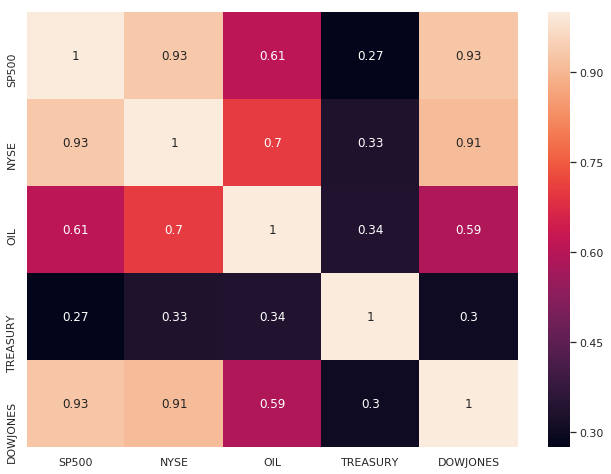

In [9]:
# we simply plot correlation matrix via pandas (market factors fit in memory)
# we assume market factors are not correlated (NASDAQ and SP500 are, so are OIL and TREASURY BONDS)
f_cor_pdf = f_ret_pdf.corr(method='spearman', min_periods=12)
sns.set(rc={'figure.figsize':(11,8)})
sns.heatmap(f_cor_pdf, annot=True)
plt.savefig('/tmp/factor_correlation.png')
plt.show()

#`STEP3` Train a model for each instrument

In [11]:
# create our feature set based on market factors and actual portfolio return
# in real life, we should obviously split set into training / testing
x_train = f_ret \
  .withColumn("features", F.array(feature_names)) \
  .dropna() \
  .select('date', 'features') \
  .join(s_ret, 'date')

display(x_train)

date,features,ticker,return
2018-05-14T00:00:00.000+0000,"List(0.00835289619341088, -0.023539799774533736, -0.1893097434315293, -0.10073387651738411, 0.025529768453617888)",BVN,0.0
2018-05-15T00:00:00.000+0000,"List(0.006865679959648944, 0.005291129782666528, -3.6767196334963625E-4, -0.02798536541807045, 0.007781384274825131)",BVN,-0.00911464643409863
2018-05-16T00:00:00.000+0000,"List(-0.004052336187627972, -0.0030783848695356804, 6.386746750354355E-4, -0.004858309151076406, -0.0025273210160091622)",BVN,-6.54236202596486E-4
2018-05-17T00:00:00.000+0000,"List(8.562100552651274E-4, -3.1618221616851395E-4, -0.017946018264405263, -0.004513224940057269, 0.0022209697282429197)",BVN,-0.01185003991749573
2018-05-18T00:00:00.000+0000,"List(0.0026356975373119174, 0.002388353890535551, 0.003969456316382334, 0.013601245944502313, -4.491284178266729E-5)",BVN,0.017722813729625874
2018-05-21T00:00:00.000+0000,"List(-0.007359590175901005, -0.006785695962775028, -0.00866162863231216, 6.523157439398113E-4, -0.011993295353433872)",BVN,0.0
2018-05-22T00:00:00.000+0000,"List(0.0031406635129492878, 0.002922101078637578, 0.013087853865834328, 0.0, 0.007177092136706679)",BVN,0.01805335943565774
2018-05-23T00:00:00.000+0000,"List(-0.0032431094088001627, 0.0018228115144908069, 0.006457530816151813, 0.020435780386981465, -0.00210775276227926)",BVN,-0.0032000027306709027
2018-05-24T00:00:00.000+0000,"List(0.002025252246426984, 0.003672160946713505, 0.011803899502490937, 0.0073529743052589535, 0.0030202099194575824)",BVN,0.012105914012059318
2018-05-25T00:00:00.000+0000,"List(0.002360028182484996, 0.004875337458412988, 0.025782781194099606, 0.01691515296717906, 0.002367404618468157)",BVN,-0.009545093150385561


In [12]:
# add non linear transformations as simple example on non linear returns
def featurize(xs):
  fs = []
  for x in xs:
    fs.append(x)
    fs.append(np.sign(x) * x**2)
    fs.append(x**3)
    fs.append(np.sign(x) * np.sqrt(abs(x)))
  return fs
  
# use pandas UDF to train multiple model (one for each instrument) in parallel
# the resulting dataframe will be the linear regression weights for each instrument
schema = StructType([StructField('ticker', StringType(), True), StructField('weights', ArrayType(FloatType()), True)])
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def train_model(pdf):
  # build market factor vectors
  # add a constant - the intercept term for each instrument i.
  X = [featurize(row) for row in np.array(pdf['features'])]
  X = sm.add_constant(X, prepend=True) 
  y = np.array(pdf['return'])
  model = sm.OLS(y, X).fit()
  w_df = pd.DataFrame(data=[[model.params]], columns=['weights'])
  w_df['ticker'] = pdf['ticker'].iloc(0)[0]
  return w_df

# the resulting dataframe easily fits in memory and will be saved as our "uber model", serialized to json
models_df = x_train.groupBy('ticker').apply(train_model).toPandas()
models_df.to_json("/tmp/models.json")

In [13]:
# simply applying weight to each market factor feature
@udf("float")
def predict_udf(xs, ps):
  fs = featurize(xs) 
  s = ps[0]
  for i, f in enumerate(fs):
    s = s + ps[i + 1] * f
  return float(s)

# we read models created at previous step
models_df = spark.createDataFrame(pd.read_json("/tmp/models.json"))

# we join model for each return to compute prediction of return vs. actual
prediction_df = x_train.join(models_df, ['ticker']) \
  .withColumn("predicted", predict_udf(F.col('features'), F.col('weights'))) \
  .withColumnRenamed('return', 'actual') \
  .select('ticker', 'date', 'predicted', 'actual')

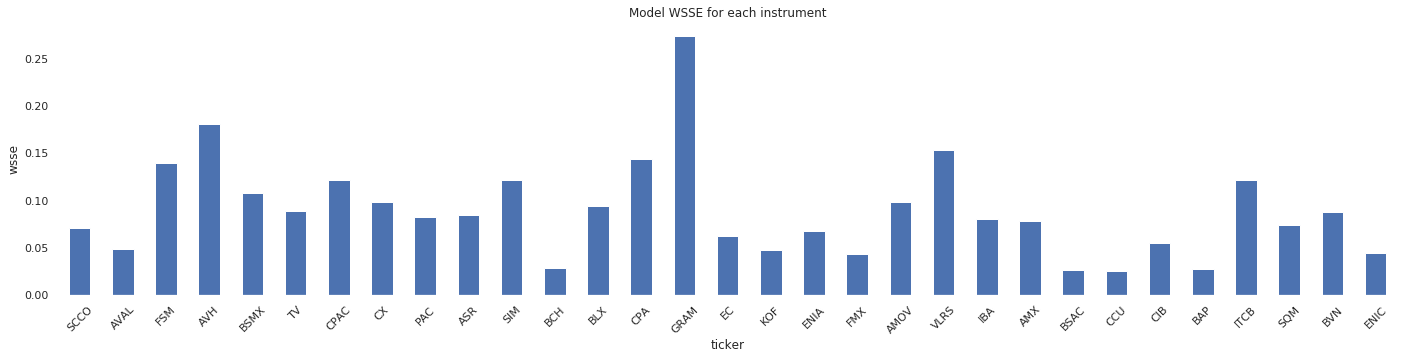

In [14]:
@udf("float")
def wsse_udf(p, a):
  return float((p - a)**2)

# compare expected vs. actual return
# sum mean square error per instrument
wsse_df = prediction_df \
  .withColumn('wsse', wsse_udf(F.col('predicted'), F.col('actual'))) \
  .groupBy('ticker') \
  .agg(F.sum('wsse')) \
  .toPandas()
 
# plot mean square error as accuracy of our model for each instrument
ax=wsse_df.plot.bar(x='ticker', y='sum(wsse)', rot=0, label=None, figsize=(24,5))
ax.get_legend().remove()
plt.title("Model WSSE for each instrument")
plt.xticks(rotation=45)
plt.ylabel("wsse")
plt.savefig("/tmp/model_wsse.png")
plt.show()

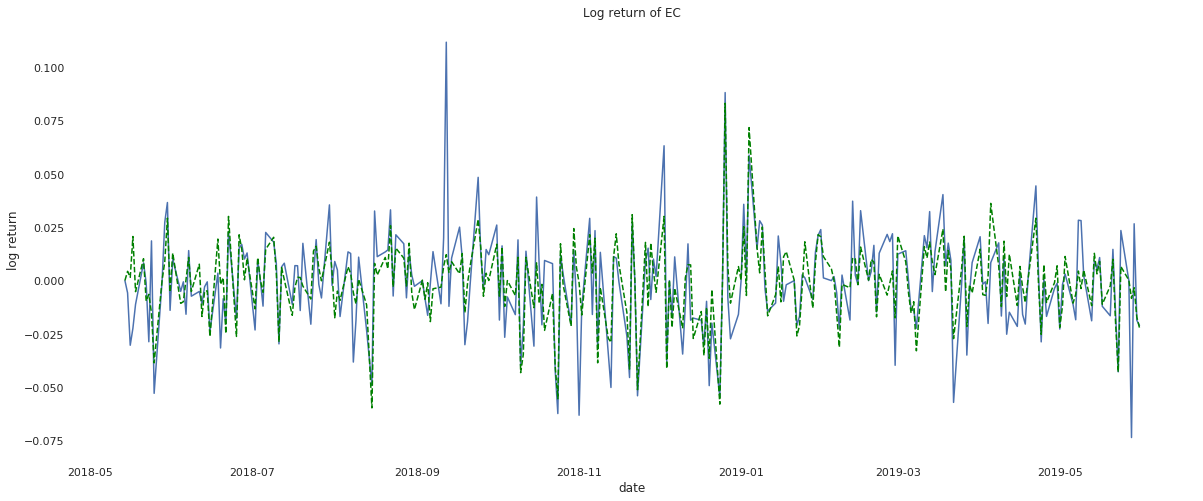

In [15]:
df = prediction_df.filter(F.col('ticker') == "EC").toPandas()
plt.figure(figsize=(20,8))
plt.plot(df.date, df.actual)
plt.plot(df.date, df.predicted, color='green', linestyle='--')
plt.title('Log return of EC')
plt.ylabel('log return')
plt.xlabel('date')
plt.show()

# `STEP4` register model

In [17]:
mlflow.log_param('delta.version.market', delta_m_version)
mlflow.log_param('delta.version.stocks', delta_s_version)
mlflow.log_artifact('/tmp/model_wsse.png')
mlflow.log_artifact('/tmp/factor_correlation.png')
mlflow.log_artifact('/tmp/models.json')
mlflow.end_run()

# `HOMEWORK` package model
We show how any function or model can be easily wrapped as a `mlflow.pyfunc` model and registered as such on ml registry. Real life VAR models are obviously more complex than a simple linear regression described here and are not necessarily out of the box sklearn or keras models. Still, they should follow same ML development standard and can easily benefit from ml-flow functionalities as long as one can express model I/O as a form of `pd.Series`, `pd.DataFrame` or `np.array`

In [19]:
import mlflow.pyfunc

class ModelRisk(mlflow.pyfunc.PythonModel):
    
  def load_context(self, context):
    # can load data from ml-flow context['data']
    print('TODO')

  def predict(self, context, input):
    # input can be a pd.Series, pd.DataFrame, np.array
    print('TODO')
    
artifacts = {"data": '/tmp/models.json'}
model_risk = ModelRisk()
mlflow.pyfunc.log_model(artifact_path = 'model', artifacts = artifacts, python_model=model_risk)
mlflow.end_run()